### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 


Wie macht man Effekte sichtbar?
Qualitätsstufen von Materialen

In [16]:
from causal.causal_model_causal_non_causal import CausalModelCBN
from plan.GifflerThompson import GifflerThompson
from plan.HodgsonMoore import HodgsonMooreAlgorithm
from factory.Operation import Operation
from simulation.Simulator import Simulator
from causal.causal_model import CausalModel
from generators.jobs_data_generator import JobsDataGenerator
from plan.PriorityRules import calculate_dynamic_priority, calculate_fcfs_priority
import random

import pandas as pd
# Beispielhafte Datenstruktur
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1],
    
#    ['p1', 1, 'a1', 17, 2],
#    ['p1', 2, 'a2', 30, 4],
#    ['p1', 3, 'a3', 14, 4],
#    ['p1', 4, 'a4', 15, 5],
#    ['p1', 5, 'a5', 25, -1],
#    ['p2', 1, 'a1', 13, 3],
#    ['p2', 2, 'a3', 15, 3],
#    ['p2', 3, 'a2', 10, 4],
#    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 1, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 1, [1,2,3]],
    ['a4', 1, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]

# causal model
observed_data = []
csv_file = 'data/observed_data.csv'
#model = CausalModel(csv_file=csv_file)
#model = CausalModelPyMC(csv_file=csv_file)
model = CausalModelCBN()
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation, tool) -> int:
 
    # 1. Preperation step
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(True, operation, tool)

    # 3. Calculation step
    new_duration = round(operation.duration * inferenced_variables['delay'],0)
    
    # Save for causal learning
    observed_data.append([tool, inferenced_variables['machine_status'], inferenced_variables['pre_processing'], inferenced_variables['delay']])
    #observed_data.append([len(operation.predecessor_operations), operation.req_machine_group_id, duration_factor])
    
    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference(operation: Operation, tool) -> int:
        
    # 2. Infer step
    inferenced_variables = model.infer_duration(False, operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference_non(operation: Operation, tool) -> int:
    return operation.duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)


Set edges by user
Testing combination: Algorithm=hill_climb, Score=BDeu
Lerne Modell mit hill_climb-Algorithmus und BDeu-Score


  0%|          | 4/1000000 [00:00<32:45:45,  8.48it/s]


Successful combination: Algorithm=hill_climb, Score=BDeu
Testing combination: Algorithm=hill_climb, Score=Bic
Lerne Modell mit hill_climb-Algorithmus und Bic-Score


  0%|          | 4/1000000 [00:00<31:03:47,  8.94it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=Bic
Testing combination: Algorithm=hill_climb, Score=K2
Lerne Modell mit hill_climb-Algorithmus und K2-Score


  0%|          | 9/1000000 [00:00<22:02:21, 12.60it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=K2
Testing combination: Algorithm=hill_climb, Score=StructureScore
Lerne Modell mit hill_climb-Algorithmus und StructureScore-Score


  0%|          | 0/1000000 [00:00<?, ?it/s]


Error with combination Algorithm=hill_climb, Score=StructureScore: 'StructureScore' object has no attribute 'local_score'
Testing combination: Algorithm=hill_climb, Score=BDsScore
Lerne Modell mit hill_climb-Algorithmus und BDsScore-Score


  0%|          | 4/1000000 [00:00<32:15:24,  8.61it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=BDsScore
Testing combination: Algorithm=hill_climb, Score=AICScore
Lerne Modell mit hill_climb-Algorithmus und AICScore-Score


  0%|          | 4/1000000 [00:00<31:20:04,  8.86it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=AICScore
Testing combination: Algorithm=tree_search, Score=BDeu
Lerne Modell mit tree_search-Algorithmus und BDeu-Score
Error with combination Algorithm=tree_search, Score=BDeu: TreeSearch.estimate() got an unexpected keyword argument 'scoring_method'
Testing combination: Algorithm=tree_search, Score=Bic
Lerne Modell mit tree_search-Algorithmus und Bic-Score
Error with combination Algorithm=tree_search, Score=Bic: TreeSearch.estimate() got an unexpected keyword argument 'scoring_method'
Testing combination: Algorithm=tree_search, Score=K2
Lerne Modell mit tree_search-Algorithmus und K2-Score
Error with combination Algorithm=tree_search, Score=K2: TreeSearch.estimate() got an unexpected keyword argument 'scoring_method'
Testing combination: Algorithm=tree_search, Score=StructureScore
Lerne Modell mit tree_search-Algorithmus und StructureScore-Score
Error with combination Algorithm=tree_search, S

Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 16.96it/s]


Failed combination: Algorithm=pc, Score=BDeu
Testing combination: Algorithm=pc, Score=Bic
Lerne Modell mit pc-Algorithmus und Bic-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 17.85it/s]


Failed combination: Algorithm=pc, Score=Bic
Testing combination: Algorithm=pc, Score=K2
Lerne Modell mit pc-Algorithmus und K2-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 17.12it/s]


Failed combination: Algorithm=pc, Score=K2
Testing combination: Algorithm=pc, Score=StructureScore
Lerne Modell mit pc-Algorithmus und StructureScore-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 17.86it/s]


Failed combination: Algorithm=pc, Score=StructureScore
Testing combination: Algorithm=pc, Score=BDsScore
Lerne Modell mit pc-Algorithmus und BDsScore-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 17.74it/s]


Failed combination: Algorithm=pc, Score=BDsScore
Testing combination: Algorithm=pc, Score=AICScore
Lerne Modell mit pc-Algorithmus und AICScore-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 17.89it/s]


Failed combination: Algorithm=pc, Score=AICScore
successful_combinations 1
Lerne Modell mit hill_climb-Algorithmus und BDeu-Score


  0%|          | 4/1000000 [00:00<32:20:39,  8.59it/s]


In [17]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

0
0
30
45
45
0
60
45
75
60
75
90
120
105
120
135
165
150
90
180
165
195
165
210
255
195
270
180
225
210
270
225
285
330
270
345
240
300
270
345
285
360
405
345
420
300
375
330
420
345
435
480
420
495
360
510
555
450
570
375
480
405
570
420
585
630
525
645
435
660
705
555
720
450
735
780
585
795
465
615
495
795
510
810
855
660
870
525
885
930
690
945
540
960
1005
720
1020
555
750
585
1020
600
795
630
1035
645
1035
1080
840
1095
660
870
690
1095
705
1110
1155
915
1170
720
1185
1230
945
1245
735
1260
1305
975
1320
750
1005
780
1320
795
1335
1380
1050
1395
810
1410
1455
1080
1470
825
1110
855
1470
870
1155
900
1485
915
1485
1530
1200
1545
930
1560
1605
1230
1620
945
1635
1680
1260
1695
960
1710
1755
1290
1770
975
1785
1830
1320
1845
990
1350
1020
1845
1035
1395
1065
1860
1080
1860
1905
1440
1920
1095
1470
1125
1920
1140
1515
1170
1935
1185
1935
1980
1560
1995
1200
1590
1230
1995
1245
1635
1275
2010
1290
2010
2055
1680
2070
1305
2085
2130
1710
2145
1320
2160
2205
1740
2220
1335
1770
1365
22

## Some statistics to compare the plan

In [18]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"{schedule_name} | {average_makespan} time units")

print(f"Average makespan across all products: ")
# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')


Average makespan across all products: 
NonCausal | 1390.4 time units
Causal | 1509.06 time units
Sim | 1213.76 time units


In [19]:
df_observed_data = pd.DataFrame(observed_data, columns=['previous_machine_pause' , 'machine_status', 'pre_processing', 'operation_duration'])
df_observed_data.to_csv("data/observed_data.csv")

Sim result

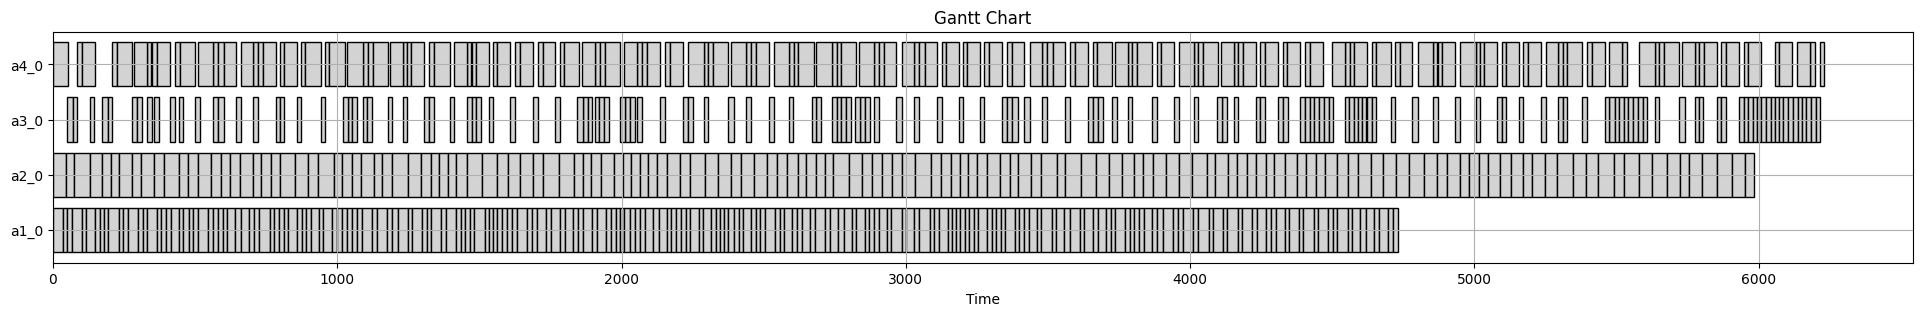

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT without causal

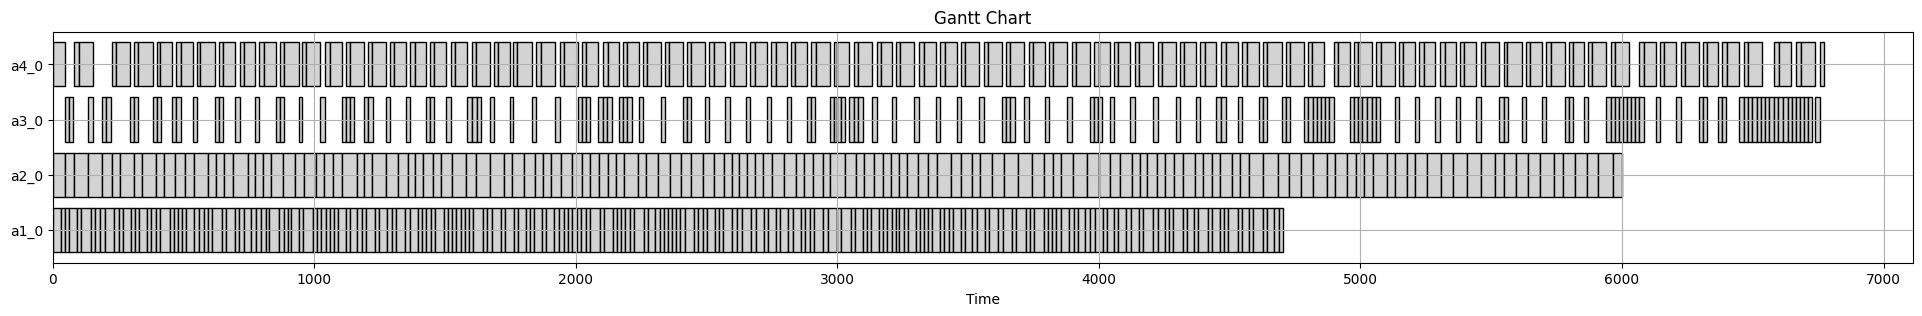

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

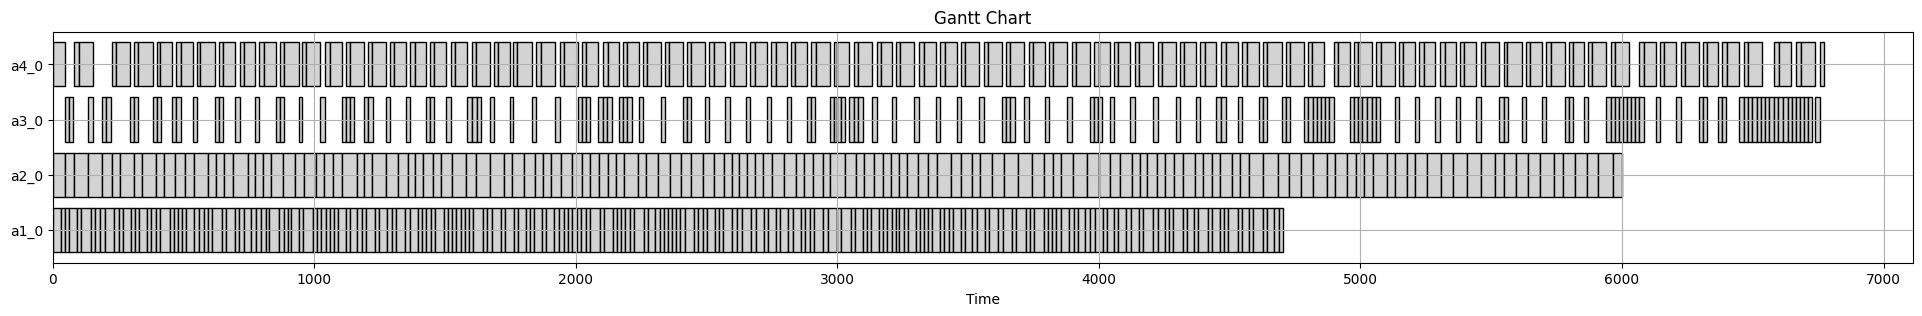

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
